In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band07_wn_1215_1380',
                          'ng_6',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_600_T_250',
                          'ng_refs_1__5',
                          'getabsth_auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform',
                          'wgt_.5__.5_.5_.5_.5_.8',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_none',
                          'crd_a3d1611',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band07_wn_1215_1380',
                          'ng_6',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_600_T_250',
                          'ng_refs_1__5',
                          'getabsth_auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform',
                          'wgt_.5__.5_.5_.5_.5_.8',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_none',
                          'crd_a3d1611',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1215

nband = 165

nv = 200

dv = 0.005

tsfc = 294.0

ng = 6

nref = 2

p_refs = (/ 1, 600 /)

t_refs = (/ 250, 250 /)

ng_refs = (/ 1, 5 /)

data wgt
     &     /.5, .5, .5, .5, .5, .8/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 5e-25

include 'mls75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

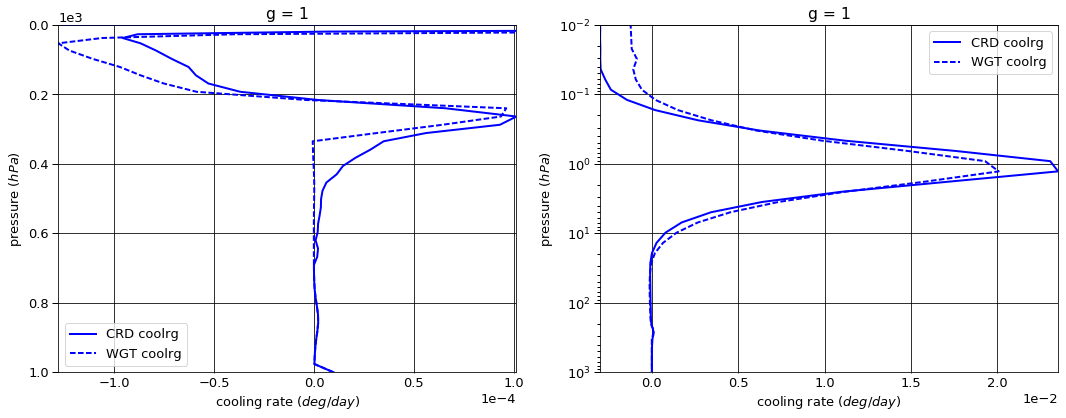

# Figure: cooling rate g-group 2

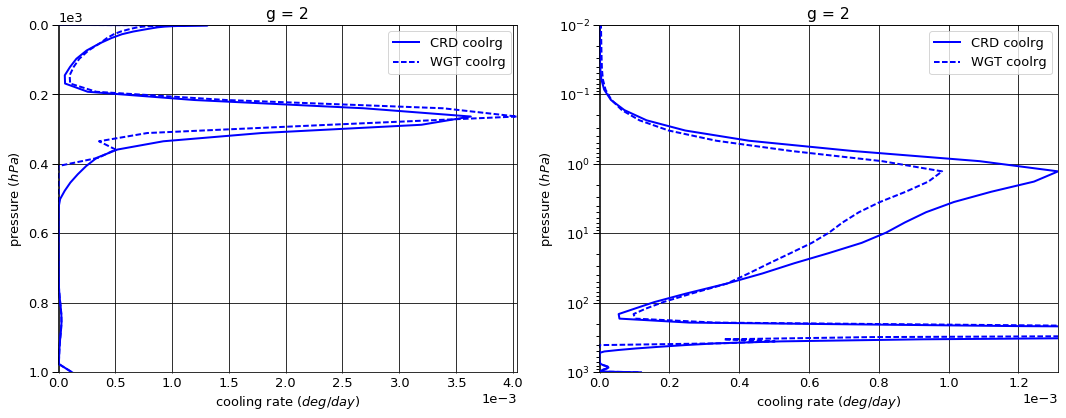

# Figure: cooling rate g-group 3

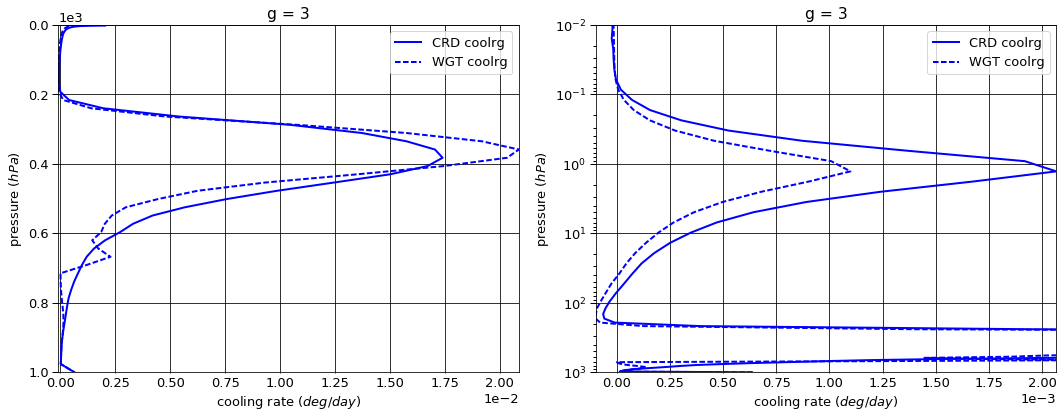

# Figure: cooling rate g-group 4

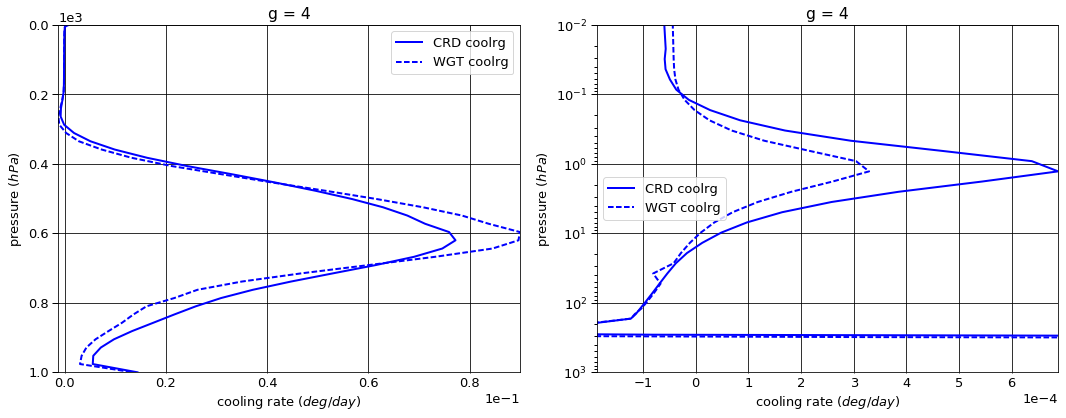

# Figure: cooling rate g-group 5

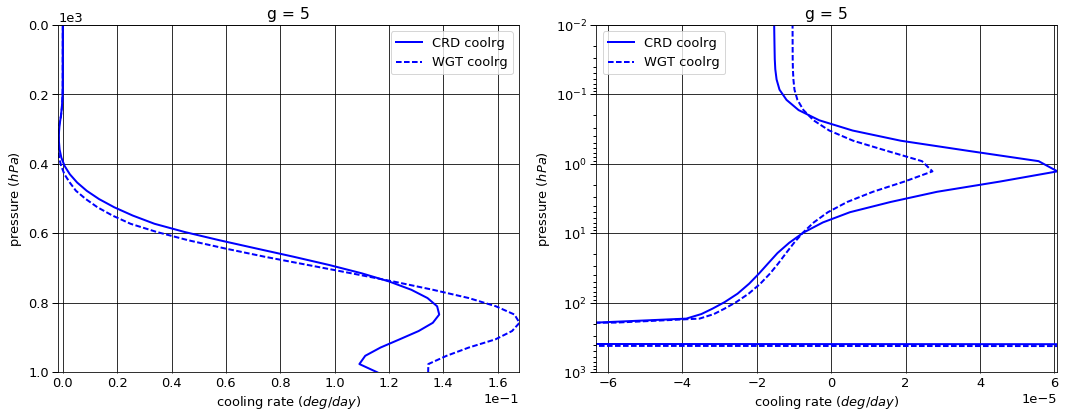

# Figure: cooling rate g-group 6

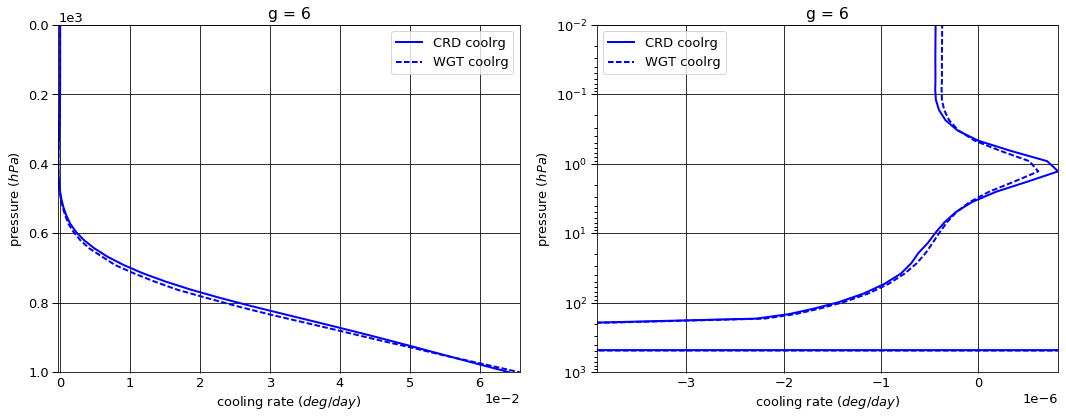

# Figure: cooling rate g-group total

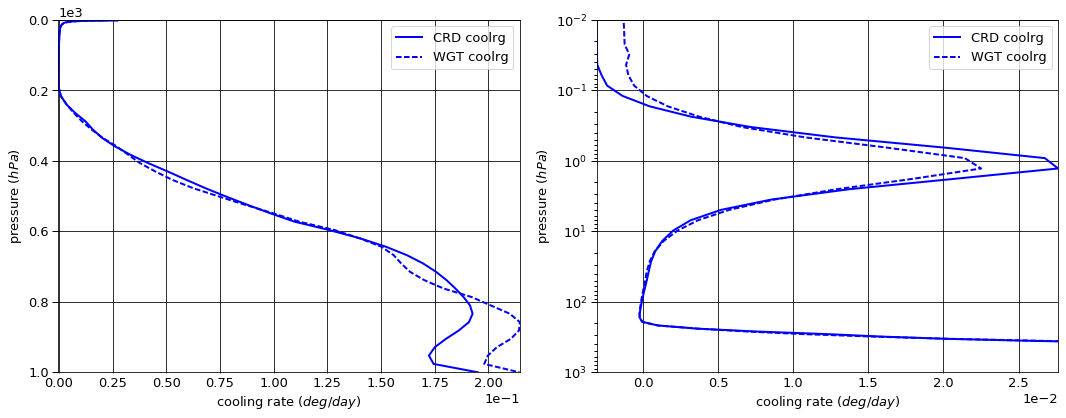

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.007546  0.000000 -0.007546
  1013.0   76    -0.027811  0.027783 -0.000027
2 0.0      1     -0.049543  0.000000 -0.049543
  1013.0   76    -0.330563  0.330231 -0.000332
3 0.0      1     -0.479295  0.000000 -0.479295
  1013.0   76    -1.800369  1.798589 -0.001780
4 0.0      1     -3.094215  0.000000 -3.094215
  1013.0   76    -6.442258  6.396394 -0.045864
5 0.0      1     -7.448023  0.000000 -7.448023
  1013.0   76    -9.837905  8.223754 -1.614152
6 0.0      1     -5.019346  0.000000 -5.019346
  1013.0   76    -5.316270  1.738584 -3.577686


WGT


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.007220  0.000000 -0.007220
  1013.0   76    -0.027811  0.027783 -0.000027
2 0.0      1     -0.045188  0.000000 -0.045188
  1013.0   76    -0.330563  0.330231 -0.000332
3 0.0      1     -0.455369  0.000000 -0.455369
  1013.0   76    -1.800369  1.798589 -0.001780
4 0.0      1     -3.038351  0.000000 -3.038351
  1013.0   76    -6.442258  6.405710 -0.036547
5 0.0      1     -7.571334  0.000000 -7.571334
  1013.0   76    -9.837905  8.629191 -1.208715
6 0.0      1     -5.044077  0.000000 -5.044077
  1013.0   76    -5.316270  1.659533 -3.656737


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000326  0.000000  0.000326
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.004355  0.000000  0.004355
  1013.0   76     0.000000  0.000000  0.000000
3 0.0      1      0.023926  0.000000  0.023926
  1013.0   76     0.000000  0.000000  0.000000
4 0.0      1      0.055864  0.000000  0.055864
  1013.0   76     0.000000  0.009316  0.009316
5 0.0      1     -0.123311  0.000000 -0.123311
  1013.0   76     0.000000  0.405437  0.405437
6 0.0      1     -0.024730  0.000000 -0.024730
  1013.0   76     0.000000 -0.079051 -0.079051

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.354833e-03
  1001.112500 75     9.830931e-06
2 0.000312    1     -3.432879e-06
  1001.112500 75     1.186497e-04
3 0.000312    1     -2.972836e-05
  1001.112500 75     6.365835e-04
4 0.000312    1     -6.698590e-05
  1001.112500 75     1.439443e-02
5 0.000312    1     -1.550013e-05
  1001.112500 75     1.156984e-01
6 0.000312    1     -4.289792e-07
  1001.112500 75     6.424695e-02


WGT


coolrg
g pressure    layer              
1 0.000312    1     -1.389734e-03
  1001.112500 75     9.830931e-06
2 0.000312    1      8.234425e-07
  1001.112500 75     1.186497e-04
3 0.000312    1     -1.953282e-05
  1001.112500 75     6.365835e-04
4 0.000312    1     -4.665043e-05
  1001.112500 75     1.351556e-02
5 0.000312    1     -1.036762e-05
  1001.112500 75     1.344322e-01
6 0.000312    1     -3.618056e-07
  1001.112500 75     6.573192e-02


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.965099e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      4.256322e-06
  1001.112500 75     0.000000e+00
3 0.000312    1      1.019553e-05
  1001.112500 75     0.000000e+00
4 0.000312    1      2.033548e-05
  1001.112500 75    -8.788660e-04
5 0.000312    1      5.132512e-06
  1001.112500 75     1.873375e-02
6 0.000312    1      6.717360e-08
  1001.112500 75     1.484973e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.097968,0.000000,-16.097968
1013.0,76,-23.755175,18.515335,-5.239840



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.161538,0.000000,-16.161538
1013.0,76,-23.755175,18.851037,-4.904138



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.06357,0.000000,-0.063570
1013.0,76,0.00000,0.335703,0.335702


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003471
1001.112500,75,0.195105



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.001466
1001.112500,75,0.214445



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002005
1001.112500,75,0.019340


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001303,0.001128
2,0.016333,0.013166
3,0.084485,0.073036
4,0.294091,0.263809
5,0.404455,0.416815
6,0.199333,0.232045


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.075413e-20
2,7.675497e-21
3,5.384191e-22
4,3.776891e-23
5,2.649405e-24
6,1.858499e-25


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [1, 5]
    p_refs = [1, 600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.075413e-20,NaN,0.001303,0.001128,0.001303,0.001128,1.0
2,7.675497e-21,0.151229,0.016333,0.013166,0.017636,0.014294,600.0
3,5.384191e-22,0.070148,0.084485,0.073036,0.102121,0.087331,600.0
4,3.776891e-23,0.070148,0.294091,0.263809,0.396212,0.351140,600.0
5,2.649405e-24,0.070148,0.404455,0.416815,0.800667,0.767955,600.0
6,1.858499e-25,0.070148,0.199333,0.232045,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  2.113832e-19  6.767936e-20   3.123304
      2     0.000312  1.336114e-22  9.379182e-23   1.424552
      3     0.000312  9.897517e-23  1.393434e-23   7.102969
      4     0.000312  2.162151e-23  1.177175e-24  18.367298
      5     0.000312  1.613929e-24  7.074977e-26  22.811792
      6     0.000312  4.955699e-26  3.417002e-27  14.503061
2     1     0.000750  2.123847e-19  6.794732e-20   3.125726
      2     0.000750  1.348700e-22  9.447166e-23   1.427624
      3     0.000750  9.957001e-23  1.396459e-23   7.130179
      4     0.000750  2.167216e-23  1.179727e-24  18.370488
      5     0.000750  1.619305e-24  7.096018e-26  22.819906
      6     0.000750  4.974052e-26  3.429261e-27  14.504734
3     1     0.001052  2.145232e-19  6.851797e-20   3.130905
      2     0.001052  1.374243e-22  9.579840e-23   1.434515
      3     0.001052  1.008395e-22  1.402412e-23   7.190429
      4     0.001052  2.178050e-23  1.184868e-24  18.382218
      5     0.001052  1.630772e-24  7.138606e-26  22.844408
      6     0.001052  5.013329e-26  3.454231e-27  14.513588
4     1     0.001476  2.168045e-19  6.912678e-20   3.136332
      2     0.001476  1.402068e-22  9.724486e-23   1.441791
      3     0.001476  1.022058e-22  1.408797e-23   7.254831
      4     0.001476  2.189663e-23  1.190388e-24  18.394540
      5     0.001476  1.643007e-24  7.184392e-26  22.869112
      6     0.001476  5.055421e-26  3.481169e-27  14.522192
5     1     0.002070  2.191058e-19  6.974118e-20   3.141698
      2     0.002070  1.430899e-22  9.875017e-23   1.449009
      3     0.002070  1.035977e-22  1.415315e-23   7.319765
      4     0.002070  2.201440e-23  1.196022e-24  18.406356
      5     0.002070  1.655352e-24  7.231182e-26  22.891852
      6     0.002070  5.098090e-26  3.508785e-27  14.529503
6     1     0.002904  2.214248e-19  7.036079e-20   3.146991
      2     0.002904  1.460905e-22  1.003308e-22   1.456088
      3     0.002904  1.050150e-22  1.422018e-23   7.384929
      4     0.002904  2.213374e-23  1.201800e-24  18.417156
      5     0.002904  1.667798e-24  7.279202e-26  22.911821
      6     0.002904  5.141311e-26  3.537209e-27  14.534935
7     1     0.004074  2.237615e-19  7.098586e-20   3.152199
      2     0.004074  1.492355e-22  1.020109e-22   1.462937
      3     0.004074  1.064594e-22  1.428990e-23   7.449976
      4     0.004074  2.225470e-23  1.207773e-24  18.426233
      5     0.004074  1.680347e-24  7.328840e-26  22.927877
      6     0.004074  5.185097e-26  3.566659e-27  14.537683
8     1     0.005714  2.261158e-19  7.161670e-20   3.157306
      2     0.005714  1.525628e-22  1.038255e-22   1.469416
      3     0.005714  1.079329e-22  1.436345e-23   7.514409
      4     0.005714  2.237734e-23  1.214009e-24  18.432591
      5     0.005714  1.693004e-24  7.380645e-26  22.938427
      6     0.005714  5.229464e-26  3.597440e-27  14.536625
9     1     0.008015  2.284877e-19  7.225384e-20   3.162292
      2     0.008015  1.561258e-22  1.058242e-22   1.475332
      3     0.008015  1.094386e-22  1.444250e-23   7.577538
      4     0.008015  2.250174e-23  1.220610e-24  18.434838
      5     0.008015  1.705773e-24  7.435393e-26  22.941259
      6     0.008015  5.274440e-26  3.629985e-27  14.530196
10    1     0.011243  2.308765e-19  7.289773e-20   3.167129
      2     0.011243  1.599987e-22  1.080764e-22   1.480423
      3     0.011243  1.109801e-22  1.452931e-23   7.638357
      4     0.011243  2.262798e-23  1.227711e-24  18.431025
      5     0.011243  1.718656e-24  7.494156e-26  22.933286
      6     0.011243  5.320039e-26  3.664893e-27  14.516220
11    1     0.015771  2.332810e-19  7.354900e-20   3.171777
      2     0.015771  1.642863e-22  1.106799e-22   1.484337
      3     0.015771  1.125625e-22  1.462712e-23   7.695462
      4     0.015771  2.275613e-23  1.235508e-24  18.418440
      5     0.015771  1.731657e-24  7.558441e-26  22

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
